In [93]:
from PINNs import Bound, PhysicsBound, PINN, NVS, NetworkTrainer, Visualization
import torch
import matplotlib.pyplot as plt

## 1. Define Physical Space

Define physical bound

In [94]:
# Define the channel geometry boundaries
bound_list = [
    Bound([0, 10], lambda x: 1 * torch.ones_like(x), True),  # Top wall
    Bound([0, 10], lambda x: 0 * torch.ones_like(x), False), # Bottom wall
    Bound([0.00001, 0.99999], lambda y: 0 * torch.ones_like(y), False, ref_axis='y'), # Inlet
    Bound([0, 1], lambda y: 10 * torch.ones_like(y), True, ref_axis='y') # Outlet
]

Plot Physical bound

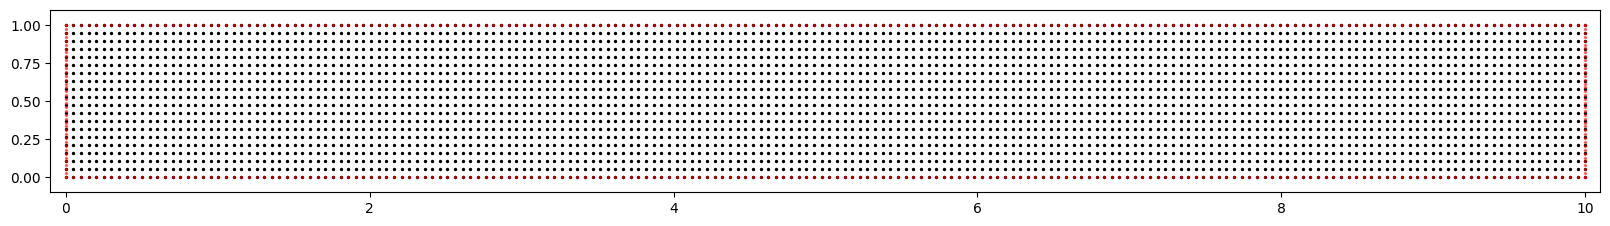

In [95]:
X, Y = Bound.sampling_area(bound_list, [200,20], [0,10], [0,1])

sampling_resolution_list = [
    200,
    200,
    40,
    40,
]

plt.figure(figsize=(20,20))
plt.scatter(X,Y,s=2, color='black')
for i,bound in enumerate(bound_list):
    x,y = bound.sampling_line(sampling_resolution_list[i])
    plt.scatter(x,y,s=2, color='red', alpha=0.5)
plt.xlim(-0.1,10.1)
plt.ylim(-0.1,1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


### Define Boundary Conditions and PDE Area

In [96]:
# Define the physics at the boundaries
physics_cond_list = [
    {'u': 0.0, 'v': 0.0},      # Top wall: No-slip
    {'u': 0.0, 'v': 0.0},      # Bottom wall: No-slip
    {'u': 0.1, 'v': 0.0},      # Inlet: Uniform inflow
    {'p': 0.0}                 # Outlet: Zero pressure
]

# Create a list of boundary condition objects and define the PDE area
boundary_conditions_list = [
    PhysicsBound.define_boundary_condition(bound, cond) 
    for bound, cond in zip(bound_list, physics_cond_list)
]
# Define PDE area
area_physics_bound = PhysicsBound.define_pde_area(
    bound_list=bound_list, 
    sampling_range_x=[0, 10], 
    sampling_range_y=[0, 1], 
    PDE_class=NVS()
)

### Sampling points

In [97]:
# Define sampling resolutions and sampling function
sampling_resolution_list = [200, 200, 40, 40]

# def uniform_sampling():
#     for i,bc in enumerate(boundary_conditions_list):
#         bc.sampling_collocation_points(sampling_resolution_list[i])
#     area_physics_bound.sampling_collocation_points([44,220])

def random_sampling():
    for i, bc in enumerate(boundary_conditions_list):
        bc.sampling_collocation_points(sampling_resolution_list[i], random=True)
    area_physics_bound.sampling_collocation_points(100, random=True)

## Define the Model and Loss Function

In [98]:
model0 = PINN(width=64, length=4, is_steady=True)

In [99]:
# Define the loss calculation function
loss_fn = torch.nn.MSELoss()
def calc_loss(model):
    # Re-sample the collocation points at each step
    random_sampling()

    # BC Loss
    bc_loss = 0
    for i, bc in enumerate(boundary_conditions_list):
        bc_loss += bc.calc_loss(model, loss_fn)

    # PDE Loss
    pde_loss = area_physics_bound.calc_loss(model)
    
    # Total Loss
    total_loss = bc_loss + pde_loss
    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [100]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.001,
    epochs=1000,
    print_every=100
)

epoch 1, total_loss: 0.01317, bc_loss: 0.01302, pde_loss: 0.00015
epoch 101, total_loss: 0.00055, bc_loss: 0.00046, pde_loss: 0.00009
epoch 201, total_loss: 0.00064, bc_loss: 0.00055, pde_loss: 0.00008
epoch 301, total_loss: 0.00060, bc_loss: 0.00049, pde_loss: 0.00011
epoch 401, total_loss: 0.00049, bc_loss: 0.00044, pde_loss: 0.00005
epoch 501, total_loss: 0.00035, bc_loss: 0.00033, pde_loss: 0.00003
epoch 601, total_loss: 0.00049, bc_loss: 0.00030, pde_loss: 0.00019
epoch 701, total_loss: 0.00047, bc_loss: 0.00037, pde_loss: 0.00010
epoch 801, total_loss: 0.00033, bc_loss: 0.00031, pde_loss: 0.00002
epoch 901, total_loss: 0.00039, bc_loss: 0.00032, pde_loss: 0.00007


Continue training with higher sampling rate

In [101]:
sampling_resolution_list = [
    3200,
    3200,
    640,
    640,
]

# def uniform_sampling():
#     for i,bc in enumerate(boundary_conditions_list):
#         bc.sampling_collocation_points(sampling_resolution_list[i])
#     area_physics_bound.sampling_collocation_points(100)

def random_sampling():
    for i,bc in enumerate(boundary_conditions_list):
        bc.sampling_collocation_points(sampling_resolution_list[i],True)
    area_physics_bound.sampling_collocation_points(500,True)

In [102]:
# For better results, continue training with a smaller learning rate
model2 = NetworkTrainer.train_adam(
    model=model1, 
    calc_loss=calc_loss, 
    learning_rate=0.0005, 
    epochs=5000, 
    print_every=500
)

epoch 1001, total_loss: 0.00041, bc_loss: 0.00034, pde_loss: 0.00007
epoch 1501, total_loss: 0.00031, bc_loss: 0.00029, pde_loss: 0.00002
epoch 2001, total_loss: 0.00027, bc_loss: 0.00024, pde_loss: 0.00003
epoch 2501, total_loss: 0.00026, bc_loss: 0.00024, pde_loss: 0.00002
epoch 3001, total_loss: 0.00030, bc_loss: 0.00028, pde_loss: 0.00002
epoch 3501, total_loss: 0.00018, bc_loss: 0.00017, pde_loss: 0.00001
epoch 4001, total_loss: 0.00020, bc_loss: 0.00018, pde_loss: 0.00002
epoch 4501, total_loss: 0.00018, bc_loss: 0.00017, pde_loss: 0.00001
epoch 5001, total_loss: 0.00018, bc_loss: 0.00016, pde_loss: 0.00001
epoch 5501, total_loss: 0.00017, bc_loss: 0.00016, pde_loss: 0.00001


## 3. Visualize the Results

In [114]:
# Create visualization object
visual_model = Visualization(area_physics_bound, model2)
visual_model.sampling_plot_points(400,40)
keyword = visual_model.process_model()
print(keyword) #printing keyword using for plotclor_select()

(['u', 'v', 'p', 'u_x', 'v_x', 'p_x', 'u_y', 'v_y', 'p_y', 'u_xx', 'v_xx', 'u_yy', 'v_yy', 'residual', 'velocity_magnitude'], ['total_loss', 'bc_loss', 'pde_loss'])


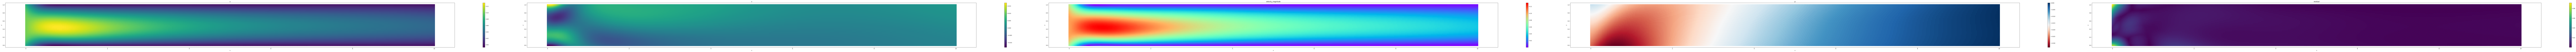

In [119]:
cmap_dict = {
    'u':None,
    'v':None,
    'velocity_magnitude': 'rainbow',
    'p':'RdBu',
    'residual':None
}
colorplot_all = visual_model.plotcolor_select(cmap_dict)
colorplot_all.savefig('channel_flow_steady_all.png')

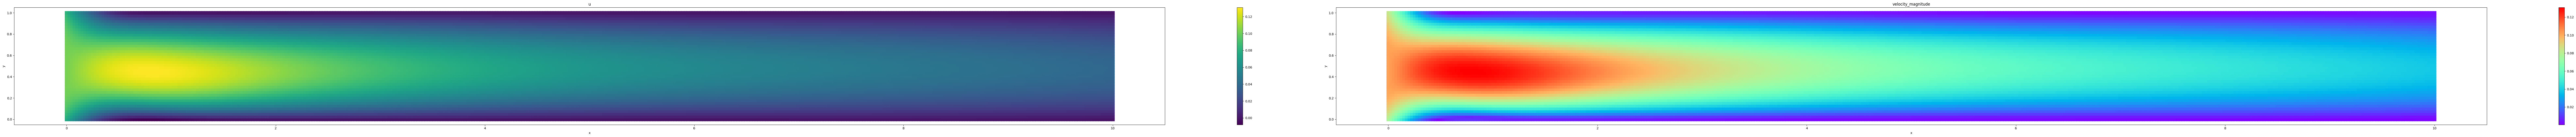

In [122]:
cmap_dict = {'u':None, 'velocity_magnitude': 'rainbow'}
colorplot = visual_model.plotcolor_select(cmap_dict)
colorplot.savefig('channel_flow_steady.png')

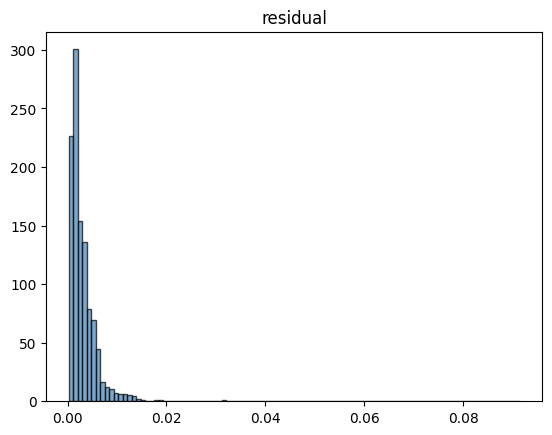

In [105]:
residual_plot = visual_model.plot_residual_distribution()
residual_plot.savefig('residual.png')

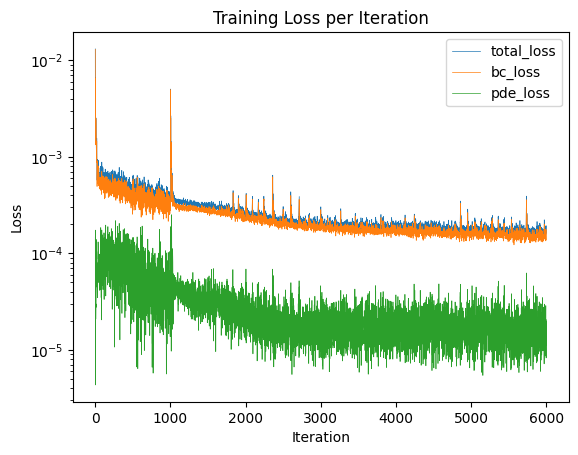

In [106]:
residual_plot = visual_model.plot_loss_evolution(log_scale=True, linewidth=0.5)
residual_plot.savefig('loss_evolution.png')

## Visualization without tools

In [107]:
import numpy as np
import PINNs
area_physics_bound.sampling_collocation_points([400,40])
area_physics_bound.process_model(model2)
area_physics_bound.process_pde()
X,Y,T = area_physics_bound.model_inputs.values()
U,V,P = area_physics_bound.model_outputs.values()
residual = area_physics_bound.PDE.calc_residual_sum()
X,Y,U,V,P,residual = PINNs.torch_to_numpy(X,Y,U,V,P,residual)
V_size = np.sqrt(U**2+V**2)


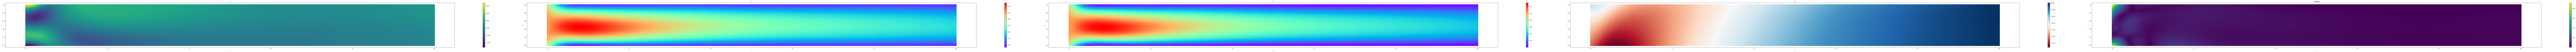

In [108]:
from PINNs import Visualization
import numpy as np
fig, axes = plt.subplots(1,5, figsize=(6*5*10,6))
s =80
Visualization.colorplot(X.flatten(),Y.flatten(),V.flatten(),axes[0],'v','viridis',s)
Visualization.colorplot(X.flatten(),Y.flatten(),U.flatten(),axes[1],'u','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),V_size.flatten(),axes[2],'V','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),P.flatten(),axes[3],'p','RdBu',s)
Visualization.colorplot(X.flatten(),Y.flatten(),residual.flatten(),axes[4],'residual','viridis',s)
plt.tight_layout()
plt.show()

In [109]:
boundary_conditions_list[2].sampling_collocation_points(1000)
boundary_conditions_list[2].pde_define(NVS())
boundary_conditions_list[2].process_model(model2)
boundary_conditions_list[2].process_pde()
X,Y,T = boundary_conditions_list[2].model_inputs.values()
U,V,P = boundary_conditions_list[2].model_outputs.values()
X,Y,U,P,V = PINNs.torch_to_numpy(X,Y,U,V,P)

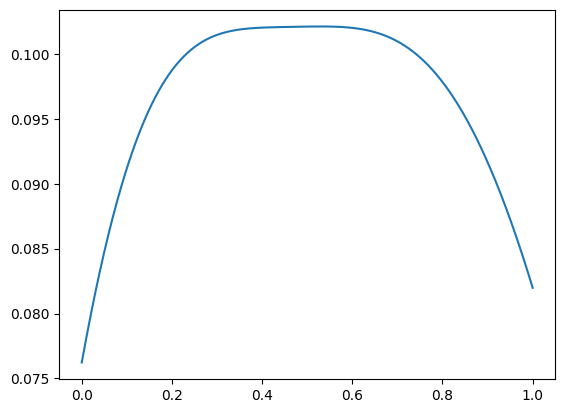

In [110]:
plt.plot(Y.flatten(), U.flatten())
plt.show()